In [1]:
import os
import gc
import argparse
import json
import random
import math
import random
from functools import reduce
import numpy as np
import pandas as pd
from scipy import sparse
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch.optim import Adam
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.distributed import DistributedSampler
from torch.utils.tensorboard import SummaryWriter
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.nn.modules.utils import consume_prefix_in_state_dict_if_present
import torch.distributed as dist
import torch.multiprocessing as mp
from performer_pytorch import PerformerLM
import scanpy as sc
import anndata as ad
from utils import *
from tqdm import tqdm
from datetime import datetime
from time import time
from collections import OrderedDict

In [2]:
%env CUDA_VISIBLE_DEVICES=0
import torch

env: CUDA_VISIBLE_DEVICES=0


In [3]:
device = "cuda:0"
CLASS=7
PAD_TOKEN_ID = CLASS-1
BATCH_SIZE=1
MASK_PROB=0.15
REPLACE_PROB=0.9
RANDOM_TOKEN_PROB = 0
MASK_TOKEN_ID = CLASS - 1
MASK_IGNORE_TOKEN_IDS = [0]

In [4]:
# Control sources of randomness
SEED=2021
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

In [5]:
class SCDataset(Dataset):
    def __init__(self, data):
        super().__init__()
        self.data = data

    def __getitem__(self, index):
        #rand_start = random.randint(0, self.data.shape[0]-1)
        full_seq = self.data[index].toarray()[0]
        full_seq[full_seq > (CLASS - 2)] = CLASS - 2
        full_seq = torch.from_numpy(full_seq).long() #long() converts to int64
        full_seq = torch.cat((full_seq, torch.tensor([0]))).to(device)
        return full_seq

    def __len__(self):
        return self.data.shape[0]

In [6]:
loss_fn = nn.CrossEntropyLoss(ignore_index = PAD_TOKEN_ID, reduction='mean').to(device)
softmax = nn.Softmax(dim=-1)

In [7]:

# get the random prob matrix and True means smaller than prob threshold
def prob_mask_like(t, prob):
    return torch.zeros_like(t).float().uniform_(0, 1) < prob

# get the mask matrix which cannot be masked
def mask_with_tokens(t, token_ids):
    init_no_mask = torch.full_like(t, False, dtype=torch.bool)
    mask = reduce(lambda acc, el: acc | (t == el), token_ids, init_no_mask)
    return mask

def get_mask_subset_with_prob(mask, prob):
    batch, seq_len, device = *mask.shape, mask.device
    max_masked = math.ceil(prob * seq_len)      # num of mask of a single sequence in average
    num_tokens = mask.sum(dim=-1, keepdim=True)     # num of pure tokens of each sequence except special tokens
    mask_excess = torch.cat((torch.zeros(0), torch.arange(mask.size(-1)).repeat(mask.size(0)))).reshape(mask.size(0),mask.size(-1)).to(device)
    mask_excess = (mask_excess >= (num_tokens * prob).ceil())        # only 15% of pure tokens can be masked
    mask_excess = mask_excess[:, :max_masked]       # get difference between 15% of pure tokens and 15% of all tokens
    rand = torch.rand((batch, seq_len), device=device).masked_fill(~mask, -1e9)     # rand (0-1) as prob, special token use -1e9
    _, sampled_indices = rand.topk(max_masked, dim=-1)      # get index of topk prob to mask
    sampled_indices = (sampled_indices + 1).masked_fill_(mask_excess, 0)        # delete difference of mask not pure
    new_mask = torch.zeros((batch, seq_len + 1), device=device)     # get (batch, seq_len) shape zero matrix
    new_mask.scatter_(-1, sampled_indices, 1)       # set masks in zero matrix as 1
    return new_mask[:, 1:].bool()       # the final mask, True is mask

def data_mask(
    data,
    mask_prob = MASK_PROB,
    replace_prob = REPLACE_PROB,
    num_tokens = None,
    random_token_prob = RANDOM_TOKEN_PROB,
    mask_token_id = MASK_TOKEN_ID,
    pad_token_id = PAD_TOKEN_ID,
    mask_ignore_token_ids = MASK_IGNORE_TOKEN_IDS
):
    mask_ignore_token_ids = set([*mask_ignore_token_ids, pad_token_id])
    # do not mask [pad] tokens, or any other tokens in the tokens designated to be excluded ([cls], [sep])
    # also do not include these special tokens in the tokens chosen at random
    no_mask = mask_with_tokens(data, mask_ignore_token_ids)   # ignore_token as True, will not be masked later
    mask = get_mask_subset_with_prob(~no_mask, mask_prob)      # get the True/False mask matrix
    # get mask indices
    ## mask_indices = torch.nonzero(mask, as_tuple=True)   # get the index of mask(nonzero value of mask matrix)
    # mask input with mask tokens with probability of `replace_prob` (keep tokens the same with probability 1 - replace_prob)
    masked_input = data.clone().detach()
    # if random token probability > 0 for mlm
    if random_token_prob > 0:
        assert num_tokens is not None, 'num_tokens keyword must be supplied when instantiating MLM if using random token replacement'
        random_token_prob = prob_mask_like(data, random_token_prob)       # get the mask matrix of random token replace
        random_tokens = torch.randint(0, num_tokens, data.shape, device=data.device)     # generate random token matrix with the same shape as input
        random_no_mask = mask_with_tokens(random_tokens, mask_ignore_token_ids)        # not masked matrix for the random token matrix
        random_token_prob &= ~random_no_mask        # get the pure mask matrix of random token replace
        random_indices = torch.nonzero(random_token_prob, as_tuple=True)        # index of random token replace
        masked_data[random_indices] = random_tokens[random_indices]        # replace some tokens by random token
    # [mask] input
    replace_prob = prob_mask_like(data, replace_prob)     # get the mask matrix of token being masked
    masked_input = masked_input.masked_fill(mask * replace_prob, mask_token_id)        # get the data has been masked by mask_token
    # mask out any tokens to padding tokens that were not originally going to be masked
    labels = data.masked_fill(~mask, pad_token_id)        # the label of masked tokens
    return masked_input, labels


# Zheng68K PBMC without g2v

In [107]:
pretrained_ckpt = "ckpts/radium-ckpts_ckpts_fromGCP/radium-ckpts/scbert-baseline/ckpts/panglao_full_without_g2v/2022-May-11-17:37:29/panglao_full_without_g2v_epoch_6.pth"
data_path = "/data/rna_rep_learning/scBERT/Zheng68K.h5ad"
g2v_file = "/data/rna_rep_learning/scBERT/gene2vec_16906.npy"
POS_EMBED_USING=False

In [108]:
#data
adata = sc.read_h5ad(data_path)
data = adata.X
SEQ_LEN = data.shape[1] + 1 # num_genes + 1

data_train, data_val = train_test_split(data, test_size=0.05, random_state=SEED)

train_dataset = SCDataset(data_train)
val_dataset = SCDataset(data_val)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

In [109]:
# init model
model = PerformerLM(
    num_tokens = CLASS,
    dim = 200,
    depth = 6,
    max_seq_len = SEQ_LEN,
    heads = 10,
    local_attn_heads = 0,
    g2v_position_emb = POS_EMBED_USING,
    #g2v_file = g2v_file
)
model.to(device);

#load checkpoint
checkpoint = torch.load(pretrained_ckpt, map_location=device)
consume_prefix_in_state_dict_if_present(checkpoint['model_state_dict'], "module.")
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [110]:
model.eval()
predictions_list = [] #will be len masked genes
truths_list = [] #will be len masked genes
most_pop_list = [] #will be len ncells
verbose=False
with torch.no_grad():
    for index, data_orig in enumerate(val_loader):
        index += 1
        data_orig = data_orig.to(device)
        data, labels = data_mask(data_orig)
        logits = model(data)
        bucket, n = torch.unique(data_orig[data!=0], return_counts=True)
        most_common_bin = bucket[torch.argmax(n)] #excluding the 0th bin
        predictions = torch.argmax(logits[data==MASK_TOKEN_ID], axis=-1).cpu()
        truths = data_orig[data==MASK_TOKEN_ID].cpu()
        if verbose:
            print("most popular bin: " + str(most_common_bin))
            print("frac genes in each bin: " + str(n/torch.sum(n)))
            print("masking accuracy in cell = {}".format(torch.sum(predictions == truths) / len(predictions)))
            print("\n")
        predictions_list.append(predictions)
        truths_list.append(truths)
        most_pop_list.append(most_common_bin.item())
        #if index==1000:
            #break;

In [111]:
import pickle
preds_dict = {'predictions':predictions_list, 'truths':truths_list, 'most_pop':most_pop_list}
fileObj = open('outputs/zheng68k_val_nog2v_maskingresults.pkl', 'wb')
pickle.dump(preds_dict,fileObj)
fileObj.close()

In [112]:
mask_acc = torch.sum(torch.cat(predictions_list) == torch.cat(truths_list)) / len(torch.cat(predictions_list))
print("masking accuracy: " + str(mask_acc))

masking accuracy: tensor(0.6806)


In [113]:
#for nog2v: fractions of cells for which the most popular expression bucket was predicted
# with no g2v, each masked genes in the same cell has the same prediction, so can just look at 1 prediction per cell
preds_per_cell = [preds[0] for preds in predictions_list]
print("fraction of cells for which the most popular expression bucket was predicted")
print((np.sum(np.array(preds_per_cell) == np.array(most_pop_list))) / len(preds_per_cell))

fraction of cells for which the most popular expression bucket was predicted
1.0


In [114]:
#make a most_pop list that is the length of masked genes
n_masked_per_cell = [len(i) for i in truths_list]
most_pop_pergene = []
for i in np.arange(len(most_pop_list)):
    most_pop_pergene += list(np.repeat(most_pop_list[i], n_masked_per_cell[i]))

In [115]:
#frac of masked predictions that == most common bucket for that cell
print("frac of masked predictions that == most common bucket for that cell")
print(np.sum(most_pop_pergene==np.array(torch.cat(predictions_list)))/len(most_pop_pergene))

frac of masked predictions that == most common bucket for that cell
1.0


In [116]:
#accuracy that would be acheived by always predicting most popular bucket
print("accuracy that would be acheived by always predicting most popular bucket")
print(np.sum(most_pop_pergene==np.array(torch.cat(truths_list)))/len(most_pop_pergene))

accuracy that would be acheived by always predicting most popular bucket
0.6806275249357683


# Zheng68K PBMC with g2v

In [117]:
pretrained_ckpt = "ckpts/panglao_full_with_g2v/2022-May-11-17:38:47/panglao_full_with_g2v_epoch_17.pth"
data_path = "/data/rna_rep_learning/scBERT/Zheng68K.h5ad"
g2v_file = "/data/rna_rep_learning/scBERT/gene2vec_16906.npy"
POS_EMBED_USING=True

In [118]:
#data
adata = sc.read_h5ad(data_path)
data = adata.X
SEQ_LEN = data.shape[1] + 1 # num_genes + 1

data_train, data_val = train_test_split(data, test_size=0.05, random_state=SEED)

train_dataset = SCDataset(data_train)
val_dataset = SCDataset(data_val)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

In [119]:
# init model
model = PerformerLM(
    num_tokens = CLASS,
    dim = 200,
    depth = 6,
    max_seq_len = SEQ_LEN,
    heads = 10,
    local_attn_heads = 0,
    g2v_position_emb = POS_EMBED_USING,
    g2v_file = g2v_file
)
model.to(device);

#load checkpoint
checkpoint = torch.load(pretrained_ckpt, map_location=device)
consume_prefix_in_state_dict_if_present(checkpoint['model_state_dict'], "module.")
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [120]:
model.eval()
predictions_list = [] #will be len masked genes
truths_list = [] #will be len masked genes
most_pop_list = [] #will be len ncells
verbose=False
with torch.no_grad():
    for index, data_orig in enumerate(val_loader):
        index += 1
        data_orig = data_orig.to(device)
        data, labels = data_mask(data_orig)
        logits = model(data)
        bucket, n = torch.unique(data_orig[data!=0], return_counts=True)
        most_common_bin = bucket[torch.argmax(n)] #excluding the 0th bin
        predictions = torch.argmax(logits[data==MASK_TOKEN_ID], axis=-1).cpu()
        truths = data_orig[data==MASK_TOKEN_ID].cpu()
        if verbose:
            print("most popular bin: " + str(most_common_bin))
            print("frac genes in each bin: " + str(n/torch.sum(n)))
            print("masking accuracy in cell = {}".format(torch.sum(predictions == truths) / len(predictions)))
            print("\n")
        predictions_list.append(predictions)
        truths_list.append(truths)
        most_pop_list.append(most_common_bin.item())
        #if index==1000:
            #break;

In [121]:
import pickle
preds_dict = {'predictions':predictions_list, 'truths':truths_list, 'most_pop':most_pop_list}
fileObj = open('outputs/zheng68k_val_g2v_maskingresults.pkl', 'wb')
pickle.dump(preds_dict,fileObj)
fileObj.close()

In [122]:
mask_acc = torch.sum(torch.cat(predictions_list) == torch.cat(truths_list)) / len(torch.cat(predictions_list))
print("masking accuracy: " + str(mask_acc))

masking accuracy: tensor(0.7882)


In [123]:
#for nog2v: fractions of cells for which the most popular expression bucket was predicted
#N/A

In [124]:
#make a most_pop list that is the length of masked genes
n_masked_per_cell = [len(i) for i in truths_list]
most_pop_pergene = []
for i in np.arange(len(most_pop_list)):
    most_pop_pergene += list(np.repeat(most_pop_list[i], n_masked_per_cell[i]))

In [125]:
#frac of masked predictions that == most common bucket for that cell
print("frac of masked predictions that == most common bucket for that cell")
print(np.sum(most_pop_pergene==np.array(torch.cat(predictions_list)))/len(most_pop_pergene))

frac of masked predictions that == most common bucket for that cell
0.7929298177252457


In [126]:
#accuracy that would be acheived by always predicting most popular bucket
print("accuracy that would be acheived by always predicting most popular bucket")
print(np.sum(most_pop_pergene==np.array(torch.cat(truths_list)))/len(most_pop_pergene))

accuracy that would be acheived by always predicting most popular bucket
0.6799454474607092


# Panglao data - no g2v

In [8]:
pretrained_ckpt = "ckpts/radium-ckpts_ckpts_fromGCP/radium-ckpts/scbert-baseline/ckpts/panglao_full_without_g2v/2022-May-11-17:37:29/panglao_full_without_g2v_epoch_6.pth"
data_path = "/data/rna_rep_learning/scBERT/panglao_human.h5ad"
g2v_file = "/data/rna_rep_learning/scBERT/gene2vec_16906.npy"
POS_EMBED_USING=False

In [9]:
#data
adata = sc.read_h5ad(data_path)
data = adata.X


/opt/conda/rpeyser/envs/rna-pretrain/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [11]:
data.max()

13.286486

In [10]:
SEQ_LEN = data.shape[1] + 1 # num_genes + 1
data_train, data_val = train_test_split(data, test_size=0.05, random_state=SEED)

train_dataset = SCDataset(data_train)
val_dataset = SCDataset(data_val)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

#### How many cells fall into each expression bucket?

(array([2.17326020e+10, 5.15606541e+08, 3.44894659e+08, 1.65865366e+08,
        9.72333360e+07, 6.82245970e+07, 2.10967310e+07, 4.84566700e+06,
        7.73225000e+05, 1.87877000e+05, 7.57810000e+04, 4.42440000e+04,
        1.72730000e+04, 3.00000000e+00]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <BarContainer object of 14 artists>)

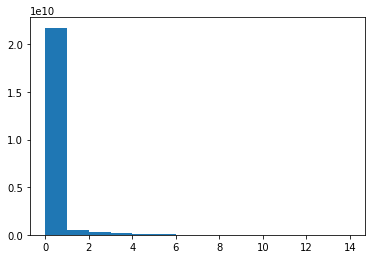

In [26]:
import matplotlib.pyplot as plt
plt.hist(np.array(adata.X.todense()).reshape(-1), bins=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14])


In [27]:
#percentages in each bin
[2.17326020e+10, 5.15606541e+08, 3.44894659e+08, 1.65865366e+08,
        9.72333360e+07, 6.82245970e+07, 2.10967310e+07, 4.84566700e+06,
        7.73225000e+05, 1.87877000e+05, 7.57810000e+04, 4.42440000e+04,
        1.72730000e+04, 3.00000000e+00]/np.sum([2.17326020e+10, 5.15606541e+08, 3.44894659e+08, 1.65865366e+08,
        9.72333360e+07, 6.82245970e+07, 2.10967310e+07, 4.84566700e+06,
        7.73225000e+05, 1.87877000e+05, 7.57810000e+04, 4.42440000e+04,
        1.72730000e+04, 3.00000000e+00])

array([9.46893796e-01, 2.24650797e-02, 1.50271290e-02, 7.22678702e-03,
       4.23647581e-03, 2.97255928e-03, 9.19188770e-04, 2.11126676e-04,
       3.36895672e-05, 8.18583830e-06, 3.30179326e-06, 1.92771989e-06,
       7.52588049e-07, 1.30710597e-10])

In [28]:
#percent of genes in final bin (5+)
np.sum([2.97255928e-03, 9.19188770e-04, 2.11126676e-04,
       3.36895672e-05, 8.18583830e-06, 3.30179326e-06, 1.92771989e-06,
       7.52588049e-07, 1.30710597e-10])

0.0041507323634095965

In [99]:
# init model
model = PerformerLM(
    num_tokens = CLASS,
    dim = 200,
    depth = 6,
    max_seq_len = SEQ_LEN,
    heads = 10,
    local_attn_heads = 0,
    g2v_position_emb = POS_EMBED_USING,
    #g2v_file = g2v_file
)
model.to(device);

#load checkpoint
checkpoint = torch.load(pretrained_ckpt, map_location=device)
consume_prefix_in_state_dict_if_present(checkpoint['model_state_dict'], "module.")
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [100]:
model.eval()
predictions_list = [] #will be len masked genes
truths_list = [] #will be len masked genes
most_pop_list = [] #will be len ncells
verbose=False
with torch.no_grad():
    for index, data_orig in enumerate(val_loader):
        index += 1
        data_orig = data_orig.to(device)
        data, labels = data_mask(data_orig)
        logits = model(data)
        bucket, n = torch.unique(data_orig[data!=0], return_counts=True)
        most_common_bin = bucket[torch.argmax(n)] #excluding the 0th bin
        predictions = torch.argmax(logits[data==MASK_TOKEN_ID], axis=-1).cpu()
        truths = data_orig[data==MASK_TOKEN_ID].cpu()
        if verbose:
            print("most popular bin: " + str(most_common_bin))
            print("frac genes in each bin: " + str(n/torch.sum(n)))
            print("masking accuracy in cell = {}".format(torch.sum(predictions == truths) / len(predictions)))
            print("\n")
        predictions_list.append(predictions)
        truths_list.append(truths)
        most_pop_list.append(most_common_bin.item())
        #if index==1000:
            #break;

In [101]:
import pickle
preds_dict = {'predictions':predictions_list, 'truths':truths_list, 'most_pop':most_pop_list}
fileObj = open('outputs/panglao_val_nog2v_maskingresults.pkl', 'wb')
pickle.dump(preds_dict,fileObj)
fileObj.close()

In [102]:
mask_acc = torch.sum(torch.cat(predictions_list) == torch.cat(truths_list)) / len(torch.cat(predictions_list))
print("masking accuracy: " + str(mask_acc))

masking accuracy: tensor(0.7231)


In [103]:
#for nog2v: fractions of cells for which the most popular expression bucket was predicted
# with no g2v, each masked genes in the same cell has the same prediction, so can just look at 1 prediction per cell
preds_per_cell = [preds[0] for preds in predictions_list]
print("fraction of cells for which the most popular expression bucket was predicted")
print((np.sum(np.array(preds_per_cell) == np.array(most_pop_list))) / len(preds_per_cell))

fraction of cells for which the most popular expression bucket was predicted
0.9985562757807896


In [104]:
#make a most_pop list that is the length of masked genes
n_masked_per_cell = [len(i) for i in truths_list]
most_pop_pergene = []
for i in np.arange(len(most_pop_list)):
    most_pop_pergene += list(np.repeat(most_pop_list[i], n_masked_per_cell[i]))

In [105]:
#frac of masked predictions that == most common bucket for that cell
print("frac of masked predictions that == most common bucket for that cell")
print(np.sum(most_pop_pergene==np.array(torch.cat(predictions_list)))/len(most_pop_pergene))

frac of masked predictions that == most common bucket for that cell
0.9990534044903671


In [106]:
#accuracy that would be acheived by always predicting most popular bucket
print("accuracy that would be acheived by always predicting most popular bucket")
print(np.sum(most_pop_pergene==np.array(torch.cat(truths_list)))/len(most_pop_pergene))

accuracy that would be acheived by always predicting most popular bucket
0.7231690398804856


# Panglao data - with g2v

In [75]:
pretrained_ckpt = "ckpts/panglao_full_with_g2v/2022-May-11-17:38:47/panglao_full_with_g2v_epoch_17.pth"
data_path = "/data/rna_rep_learning/scBERT/panglao_human.h5ad"
g2v_file = "/data/rna_rep_learning/scBERT/gene2vec_16906.npy"
POS_EMBED_USING=True

In [73]:
#data
adata = sc.read_h5ad(data_path)
data = adata.X
SEQ_LEN = data.shape[1] + 1 # num_genes + 1

data_train, data_val = train_test_split(data, test_size=0.05, random_state=SEED)

train_dataset = SCDataset(data_train)
val_dataset = SCDataset(data_val)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

/opt/conda/rpeyser/envs/rna-pretrain/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [76]:
# init model
model = PerformerLM(
    num_tokens = CLASS,
    dim = 200,
    depth = 6,
    max_seq_len = SEQ_LEN,
    heads = 10,
    local_attn_heads = 0,
    g2v_position_emb = POS_EMBED_USING,
    g2v_file = g2v_file
)
model.to(device);

#load checkpoint
checkpoint = torch.load(pretrained_ckpt, map_location=device)
consume_prefix_in_state_dict_if_present(checkpoint['model_state_dict'], "module.")
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [77]:
model.eval()
predictions_list = [] #will be len masked genes
truths_list = [] #will be len masked genes
most_pop_list = [] #will be len ncells
verbose=False
with torch.no_grad():
    for index, data_orig in enumerate(val_loader):
        index += 1
        data_orig = data_orig.to(device)
        data, labels = data_mask(data_orig)
        logits = model(data)
        bucket, n = torch.unique(data_orig[data!=0], return_counts=True)
        most_common_bin = bucket[torch.argmax(n)] #excluding the 0th bin
        predictions = torch.argmax(logits[data==MASK_TOKEN_ID], axis=-1).cpu()
        truths = data_orig[data==MASK_TOKEN_ID].cpu()
        if verbose:
            print("most popular bin: " + str(most_common_bin))
            print("frac genes in each bin: " + str(n/torch.sum(n)))
            print("masking accuracy in cell = {}".format(torch.sum(predictions == truths) / len(predictions)))
            print("\n")
        predictions_list.append(predictions)
        truths_list.append(truths)
        most_pop_list.append(most_common_bin.item())
        #if index==1000:
            #break;

In [82]:
import pickle
preds_dict = {'predictions':predictions_list, 'truths':truths_list, 'most_pop':most_pop_list}
fileObj = open('outputs/panglao_val_g2v_maskingresults.pkl', 'wb')
pickle.dump(preds_dict,fileObj)
fileObj.close()

In [83]:
mask_acc = torch.sum(torch.cat(predictions_list) == torch.cat(truths_list)) / len(torch.cat(predictions_list))
print("masking accuracy: " + str(mask_acc))

masking accuracy: tensor(0.7845)


In [ ]:
#for nog2v: fractions of cells for which the most popular expression bucket was predicted
#N/A

In [91]:
#make a most_pop list that is the length of masked genes
n_masked_per_cell = [len(i) for i in truths_list]
most_pop_pergene = []
for i in np.arange(len(most_pop_list)):
    most_pop_pergene += list(np.repeat(most_pop_list[i], n_masked_per_cell[i]))

In [94]:
#frac of masked predictions that == most common bucket for that cell
print("frac of masked predictions that == most common bucket for that cell")
print(np.sum(most_pop_pergene==np.array(torch.cat(predictions_list)))/len(most_pop_pergene))

frac of masked predictions that == most common bucket for that cell
0.8377435863633439


In [96]:
#accuracy that would be acheived by always predicting most popular bucket
print("accuracy that would be acheived by always predicting most popular bucket")
print(np.sum(most_pop_pergene==np.array(torch.cat(truths_list)))/len(most_pop_pergene))

accuracy that would be acheived by always predicting most popular bucket
0.7234092876125383
